In [1]:
'''from google.colab import drive
drive.mount('/content/drive')

import zipfile

zip_path = '/content/drive/MyDrive/trafic_32.zip'
extract_path = '/content/trafic_32'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)'''

"from google.colab import drive\ndrive.mount('/content/drive')\n\nimport zipfile\n\nzip_path = '/content/drive/MyDrive/trafic_32.zip'\nextract_path = '/content/trafic_32'\n\nwith zipfile.ZipFile(zip_path, 'r') as zip_ref:\n    zip_ref.extractall(extract_path)"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import numpy as np

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


In [4]:
image_size = 32
data_dir = './trafic_32/'
batch_size = 64
val_split = 0.1

In [5]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
print(dataset.class_to_idx)

total_size = len(dataset)
val_size = int(total_size * val_split)
train_size = total_size - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Loadery
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

{'00000': 0, '00001': 1, '00002': 2, '00003': 3, '00004': 4, '00005': 5, '00006': 6, '00007': 7, '00008': 8, '00009': 9, '00010': 10, '00011': 11, '00012': 12, '00013': 13, '00014': 14, '00015': 15, '00016': 16, '00017': 17, '00018': 18, '00019': 19, '00020': 20, '00021': 21, '00022': 22, '00023': 23, '00024': 24, '00025': 25, '00026': 26, '00027': 27, '00028': 28, '00029': 29, '00030': 30, '00031': 31, '00032': 32, '00033': 33, '00034': 34, '00035': 35, '00036': 36, '00037': 37, '00038': 38, '00039': 39, '00040': 40, '00041': 41, '00042': 42}


In [6]:
print(dataset[1])
print(dataset[0][0].shape)

(tensor([[[-0.4275, -0.3804, -0.4039,  ..., -0.4353, -0.3882, -0.4824],
         [-0.5294, -0.4588, -0.3176,  ..., -0.3176, -0.4118, -0.4275],
         [-0.5451, -0.4588, -0.3176,  ..., -0.1843, -0.3647, -0.4667],
         ...,
         [ 0.2314,  0.2235,  0.0902,  ..., -0.3804, -0.3333, -0.2314],
         [-0.1373, -0.1608, -0.1765,  ..., -0.4039, -0.2706, -0.2000],
         [-0.4275, -0.3412, -0.2157,  ..., -0.4510, -0.2627, -0.2471]],

        [[-0.4196, -0.3725, -0.4196,  ..., -0.4275, -0.3725, -0.4667],
         [-0.4824, -0.4431, -0.3255,  ..., -0.3569, -0.4275, -0.4275],
         [-0.4431, -0.3961, -0.3490,  ..., -0.3412, -0.4510, -0.5137],
         ...,
         [ 0.0118,  0.0667,  0.0431,  ..., -0.3647, -0.3647, -0.2784],
         [-0.2157, -0.2392, -0.2706,  ..., -0.3255, -0.2157, -0.1373],
         [-0.4275, -0.3725, -0.3333,  ..., -0.3647, -0.1529, -0.1373]],

        [[-0.4039, -0.3569, -0.3961,  ..., -0.3882, -0.3804, -0.4902],
         [-0.4980, -0.4667, -0.3412,  ..., -

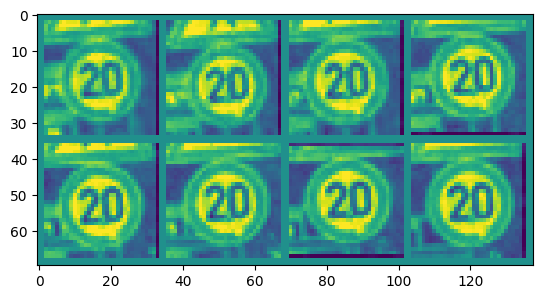

In [7]:
def get_train_images(num):
    return torch.stack([dataset[i][0] for i in range(10,10+num)], dim=0)

plt.imshow(torchvision.utils.make_grid(get_train_images(8), nrow=4)[0]);

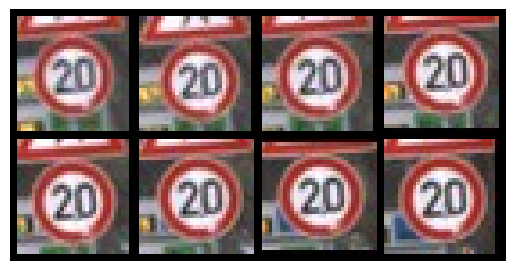

In [8]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def get_train_images(num):
    images = torch.stack([dataset[i][0] for i in range(10, 10 + num)], dim=0)
    images = images * 0.5 + 0.5
    return images

images = get_train_images(8)

grid = vutils.make_grid(images, nrow=4, padding=2, normalize=False)

grid = grid.permute(1, 2, 0)

plt.imshow(grid)
plt.axis('off')
plt.show()

In [9]:
def corrupt(x, amount):
    noise = torch.randn_like(x)
    amount = amount.view(-1, 1, 1, 1)
    noisy_x = x * (1 - amount) + noise * amount
    return noisy_x.clamp(-1, 1)

Input shape: torch.Size([43, 3, 32, 32])


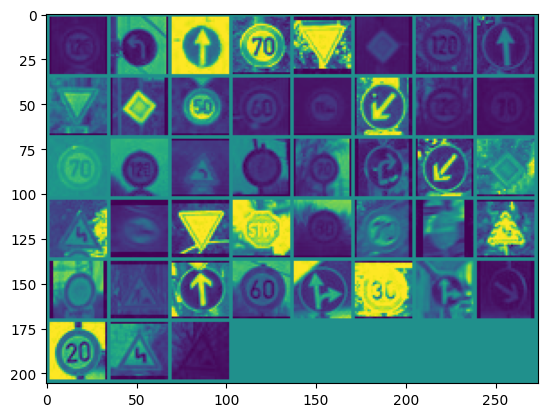

In [10]:
x, y = next(iter(train_loader))
x = x[:43]
print('Input shape:', x.shape)
plt.imshow(torchvision.utils.make_grid(x)[0]);

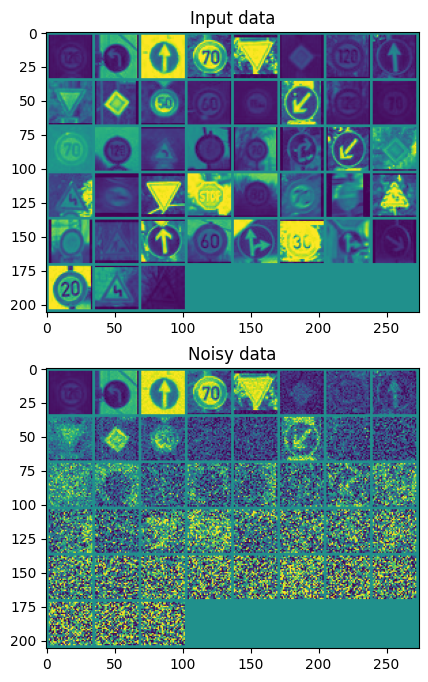

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0])

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

axs[1].set_title('Noisy data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0]);

In [12]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]  # [B, D/2]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)  # [B, D]
        return emb

In [13]:
class BasicUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_classes=43, emb_dim=128):
        super().__init__()
        self.time_embedding = nn.Sequential(
            SinusoidalPosEmb(emb_dim),
            nn.Linear(emb_dim, emb_dim * 2),
            nn.SiLU(),
            nn.Linear(emb_dim * 2, emb_dim)
        )
        self.class_embedding = nn.Embedding(num_classes, emb_dim)
        self.cond_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, emb_dim)
        )

        self.down_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.BatchNorm2d(32),
            ),
            nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.BatchNorm2d(64),
            ),
            nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=5, padding=2),
                nn.BatchNorm2d(128),
            ),
            nn.Sequential(
                nn.Conv2d(128, 128, kernel_size=5, padding=2),
                nn.BatchNorm2d(128),
            ),
        ])

        self.up_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(128 + emb_dim, 128, kernel_size=5, padding=2),
                nn.BatchNorm2d(128),
            ),
            nn.Sequential(
                nn.Conv2d(128, 64, kernel_size=5, padding=2),
                nn.BatchNorm2d(64),
            ),
            nn.Sequential(
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.BatchNorm2d(32),
            ),
            nn.Sequential(
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
                nn.BatchNorm2d(out_channels),
            ),
        ])

        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)
        self.tanh = nn.Tanh()

    def forward(self, x, y, t):
        t_emb = self.time_embedding(t)
        y_emb = self.class_embedding(y)
        cond_emb = self.cond_proj(t_emb + y_emb)

        h = []
        for i, l in enumerate(self.down_layers):
            x = l(x)
            x = self.act(x)
            if i < 2:
                h.append(x)
                x = self.downscale(x)

        cond = cond_emb[:, :, None, None].expand(-1, -1, x.shape[2], x.shape[3])
        x = torch.cat([x, cond], dim=1)

        for i, l in enumerate(self.up_layers):
            if i > 1:
                x = self.upscale(x)
                x += h.pop()
            x = l(x)
            x = self.act(x)
        return x

In [14]:
net = BasicUNet().to(device)
net

BasicUNet(
  (time_embedding): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=128, out_features=256, bias=True)
    (2): SiLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
  )
  (class_embedding): Embedding(43, 128)
  (cond_proj): Sequential(
    (0): SiLU()
    (1): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(


In [15]:
def tensor_to_image(tensor, normalize=True):
    tensor = tensor.cpu().detach()
    print(f"Tensor min: {tensor.min().item():.4f}, max: {tensor.max().item():.4f}")
    if normalize:
        tensor = (tensor + 1) / 2
        tensor = tensor.clamp(0, 1)
    tensor = tensor.permute(1, 2, 0)
    return tensor.numpy()

In [16]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.86it/s]


Finished epoch 0. Average loss for this epoch: 0.286550
Sample 1:
Tensor min: -1.0000, max: 0.8039
Tensor min: -1.0000, max: 0.7915
Tensor min: -0.2419, max: 1.2188
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2257, max: 1.5885
Sample 3:
Tensor min: -1.0000, max: 0.4353
Tensor min: -1.0000, max: 0.9628
Tensor min: -0.2412, max: 0.6456


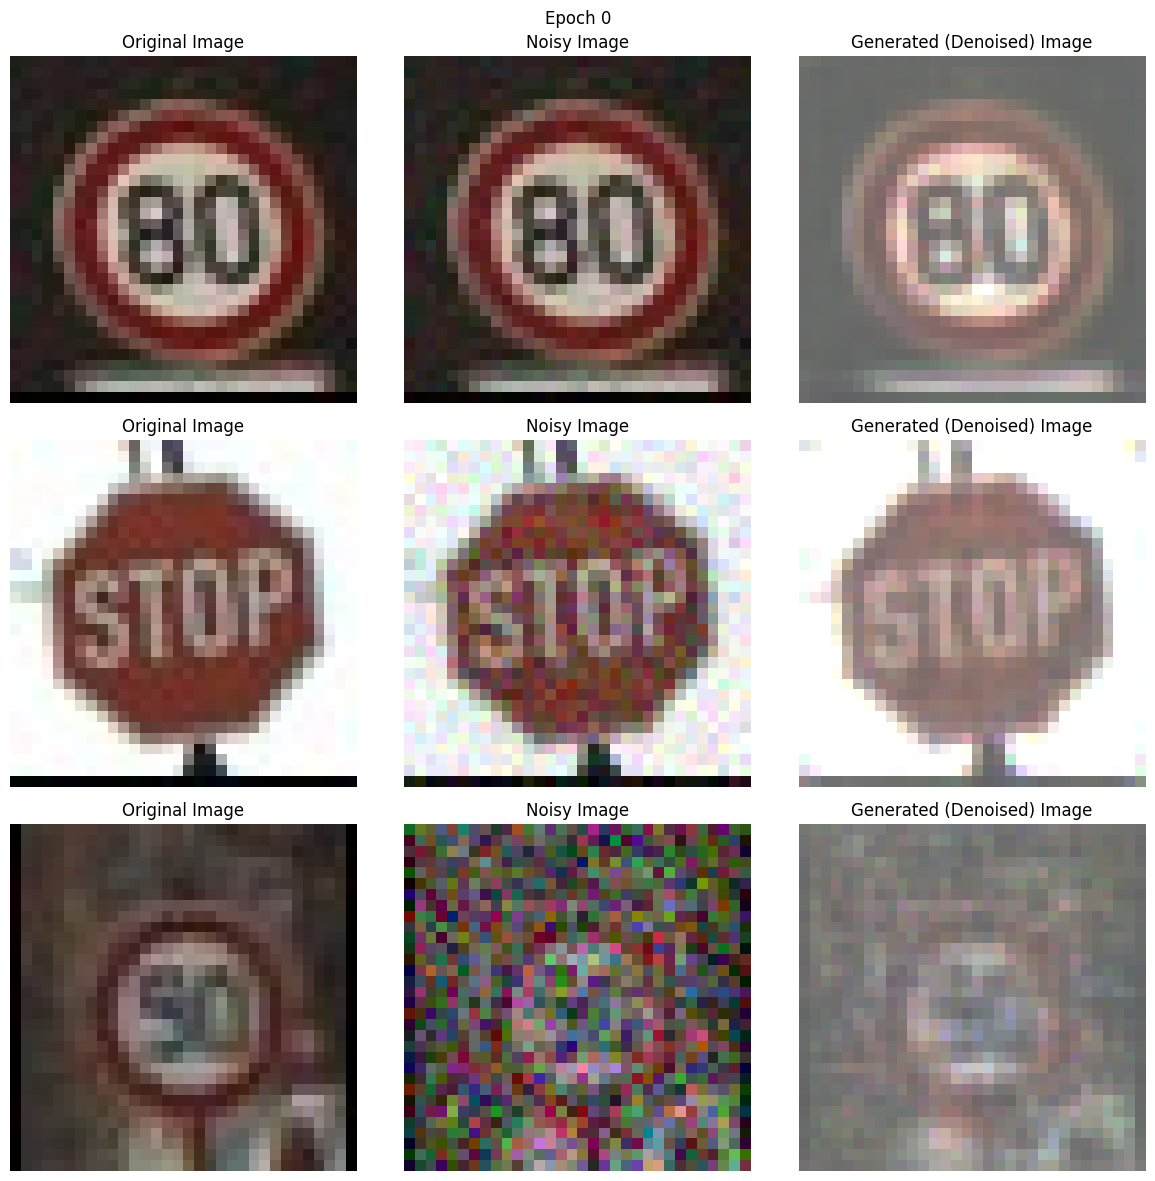

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:22<00:00, 24.17it/s]


Finished epoch 1. Average loss for this epoch: 0.245780
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2701, max: 1.5109
Sample 2:
Tensor min: -1.0000, max: -0.4745
Tensor min: -1.0000, max: -0.0718
Tensor min: -0.2528, max: -0.0622
Sample 3:
Tensor min: -1.0000, max: -0.3412
Tensor min: -1.0000, max: 0.4359
Tensor min: -0.2710, max: 0.2515


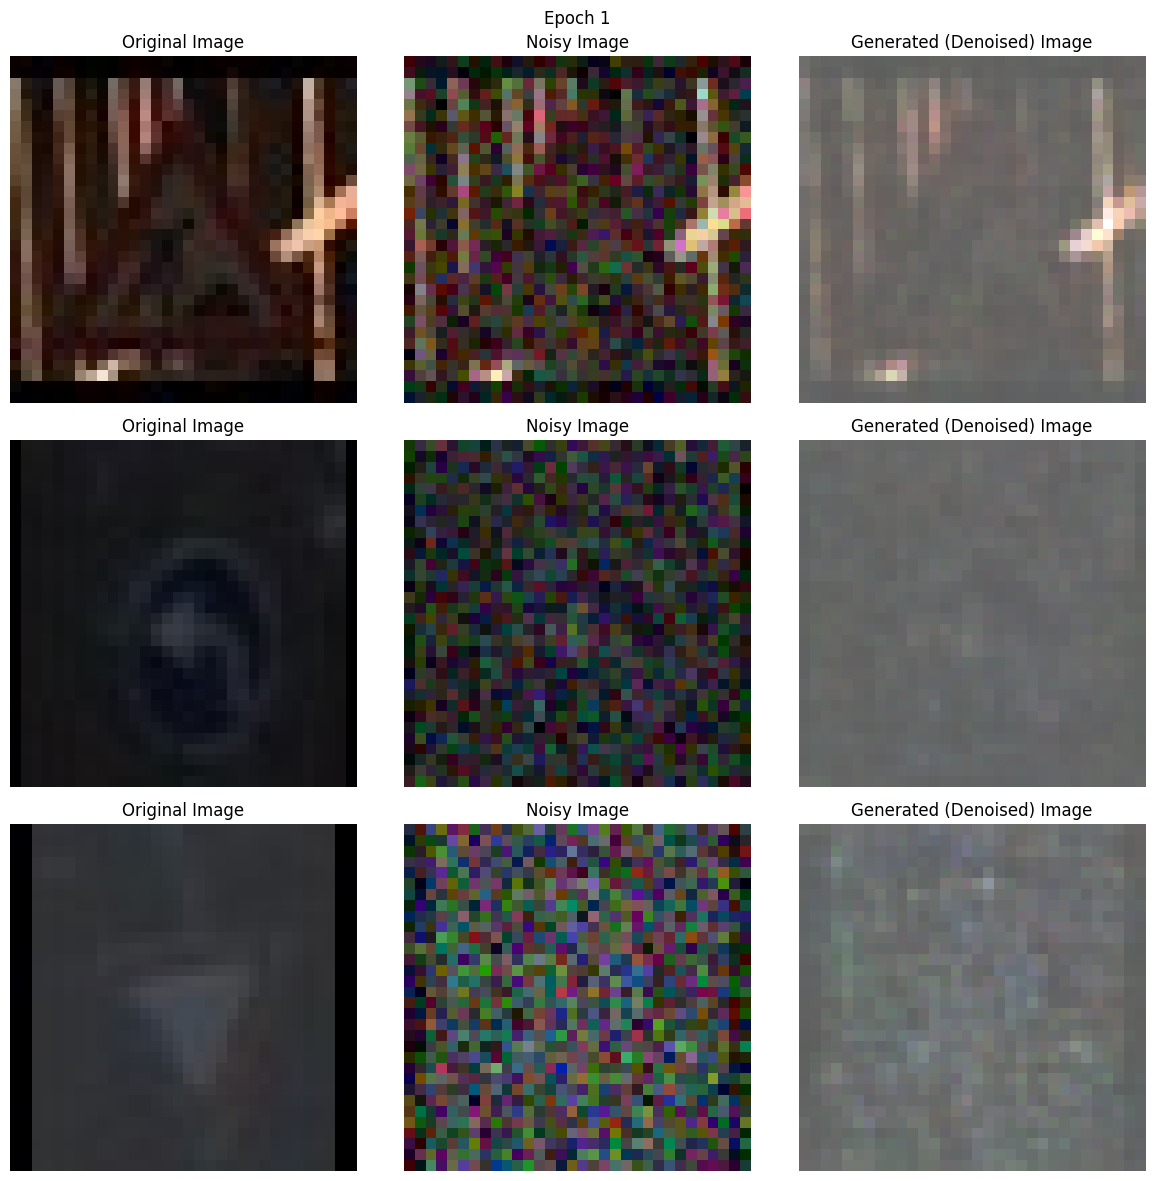

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:22<00:00, 24.18it/s]


Finished epoch 2. Average loss for this epoch: 0.228500
Sample 1:
Tensor min: -1.0000, max: -0.5529
Tensor min: -1.0000, max: 0.1292
Tensor min: -0.2727, max: -0.1071
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2640, max: 1.5452
Sample 3:
Tensor min: -0.9608, max: 0.6784
Tensor min: -1.0000, max: 0.7805
Tensor min: -0.2610, max: 0.8731


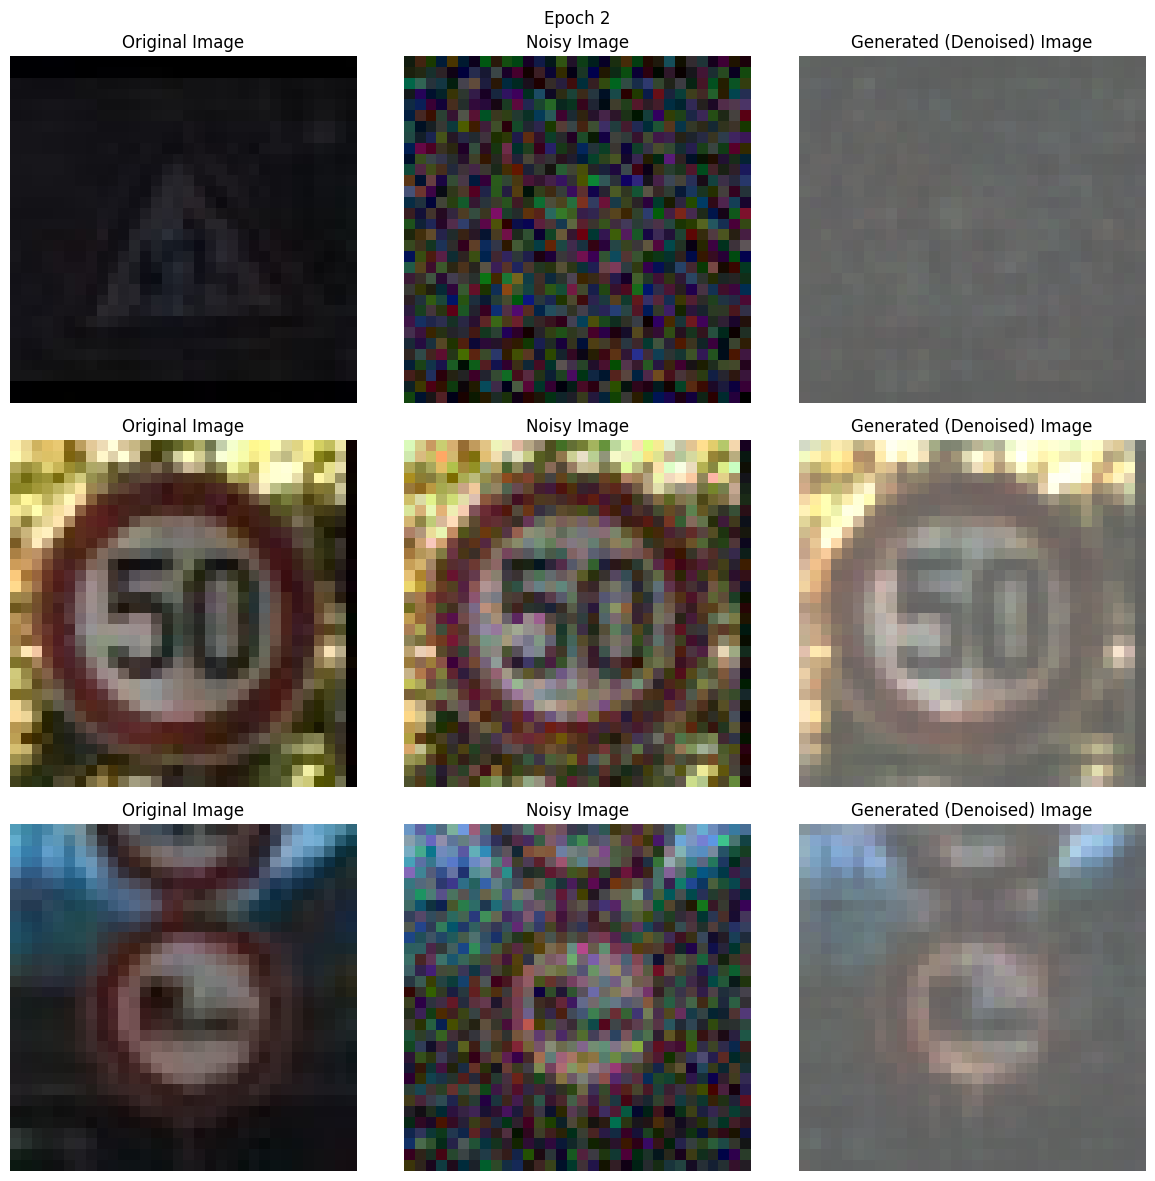

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:22<00:00, 24.19it/s]


Finished epoch 3. Average loss for this epoch: 0.215177
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2748, max: 1.6380
Sample 2:
Tensor min: -1.0000, max: -0.5843
Tensor min: -1.0000, max: -0.1920
Tensor min: -0.2720, max: -0.1675
Sample 3:
Tensor min: -1.0000, max: -0.2157
Tensor min: -1.0000, max: -0.1800
Tensor min: -0.2784, max: 0.1017


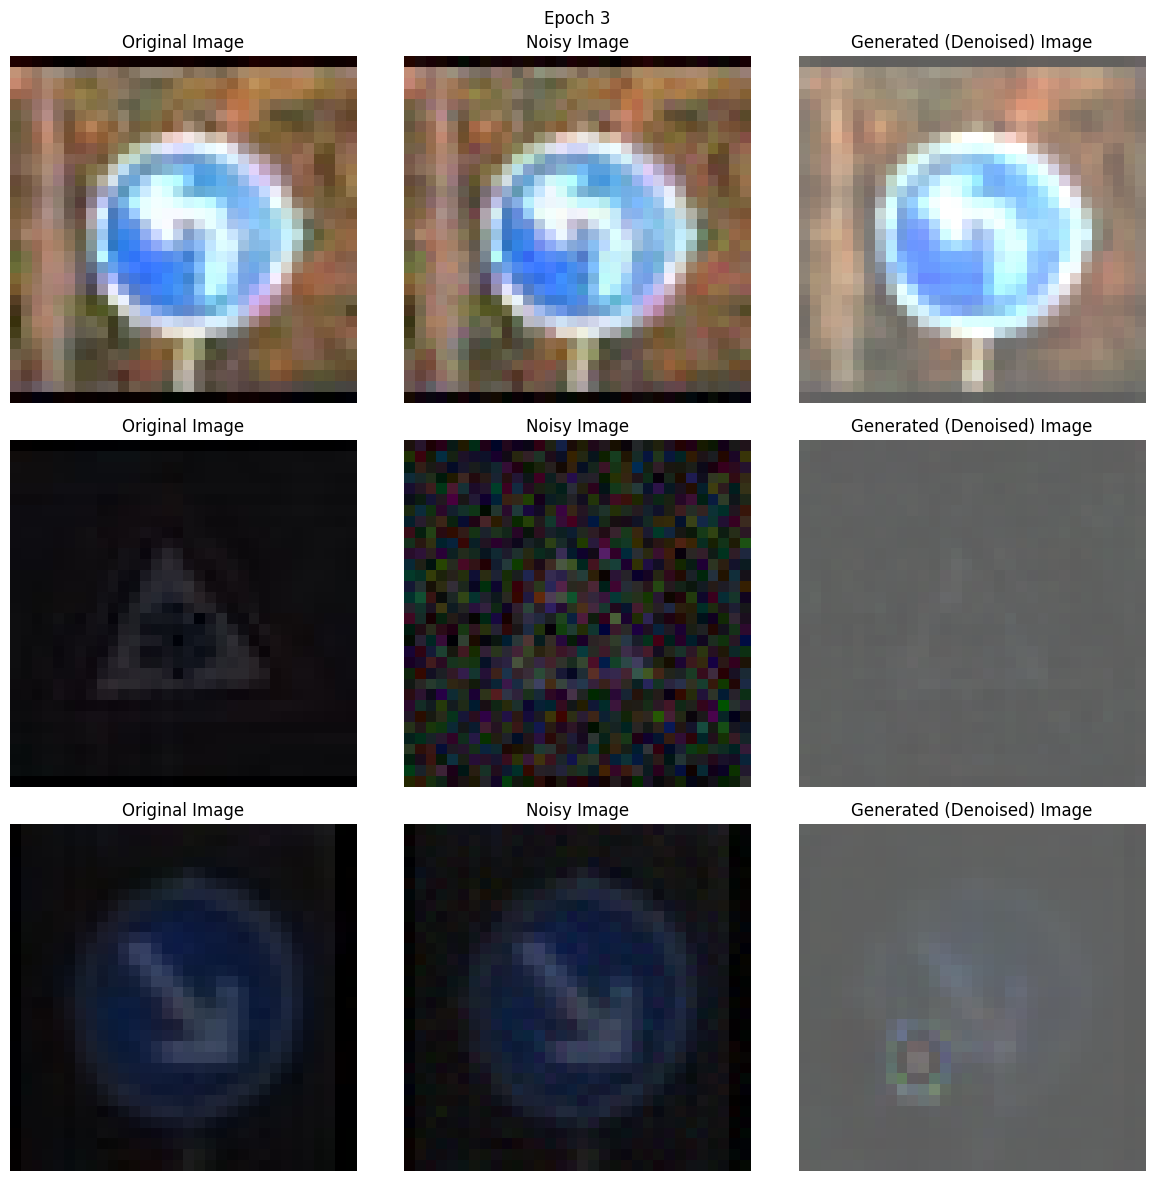

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:22<00:00, 24.16it/s]


Finished epoch 4. Average loss for this epoch: 0.203361
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2781, max: 1.0087
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2700, max: 1.0029
Sample 3:
Tensor min: -1.0000, max: 0.6863
Tensor min: -1.0000, max: 0.6864
Tensor min: -0.2716, max: 0.5720


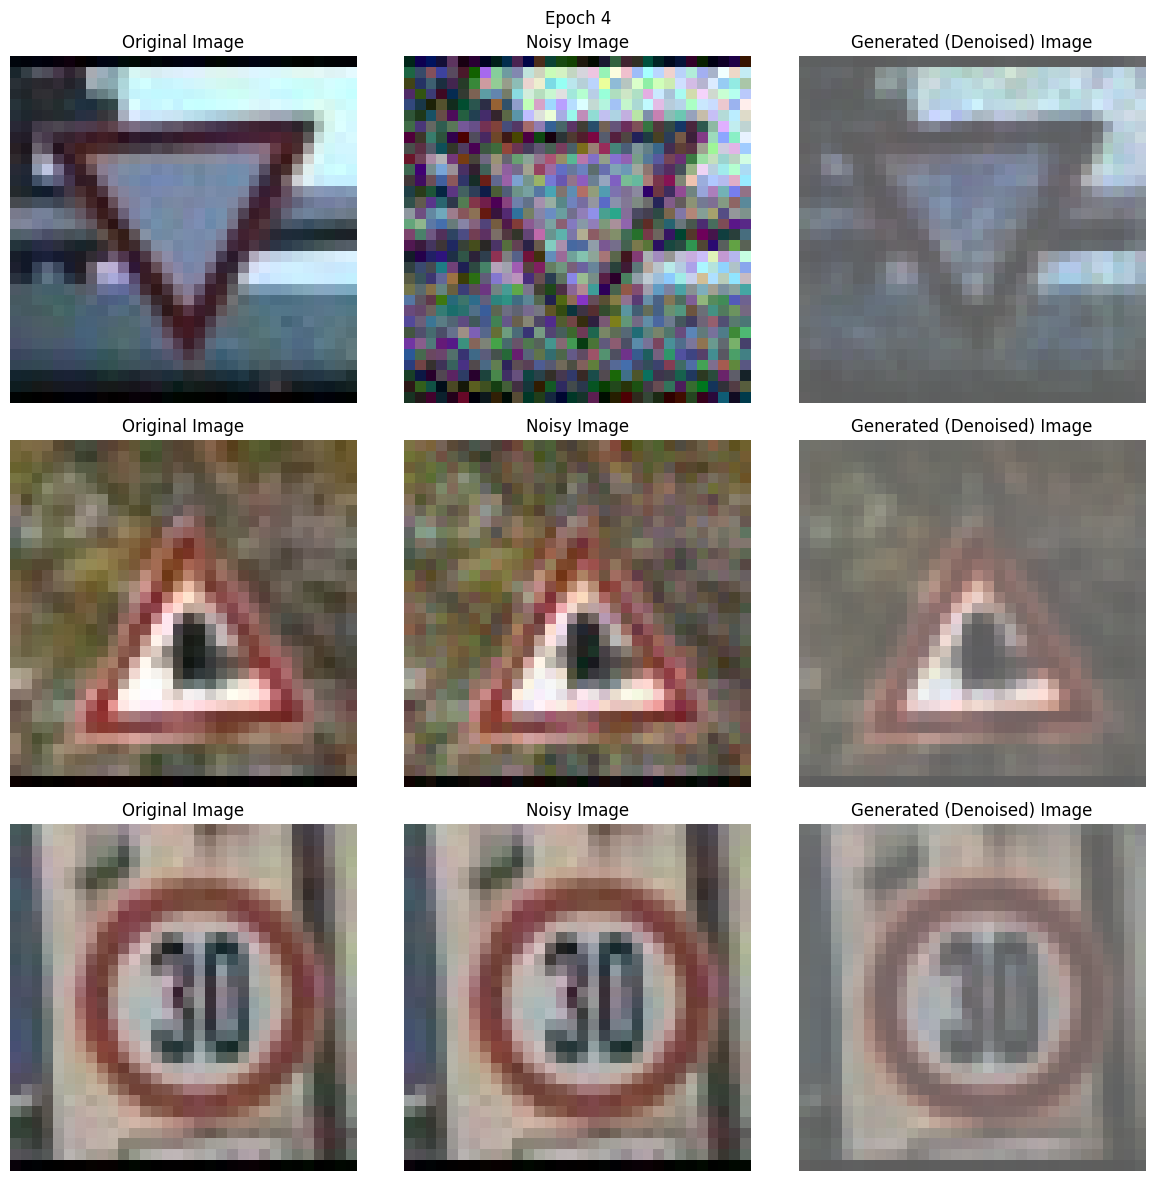

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:22<00:00, 24.11it/s]


Finished epoch 5. Average loss for this epoch: 0.194170
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2682, max: 1.3811
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2728, max: 1.3447
Sample 3:
Tensor min: -1.0000, max: 0.0902
Tensor min: -1.0000, max: 0.8562
Tensor min: -0.2714, max: 0.5548


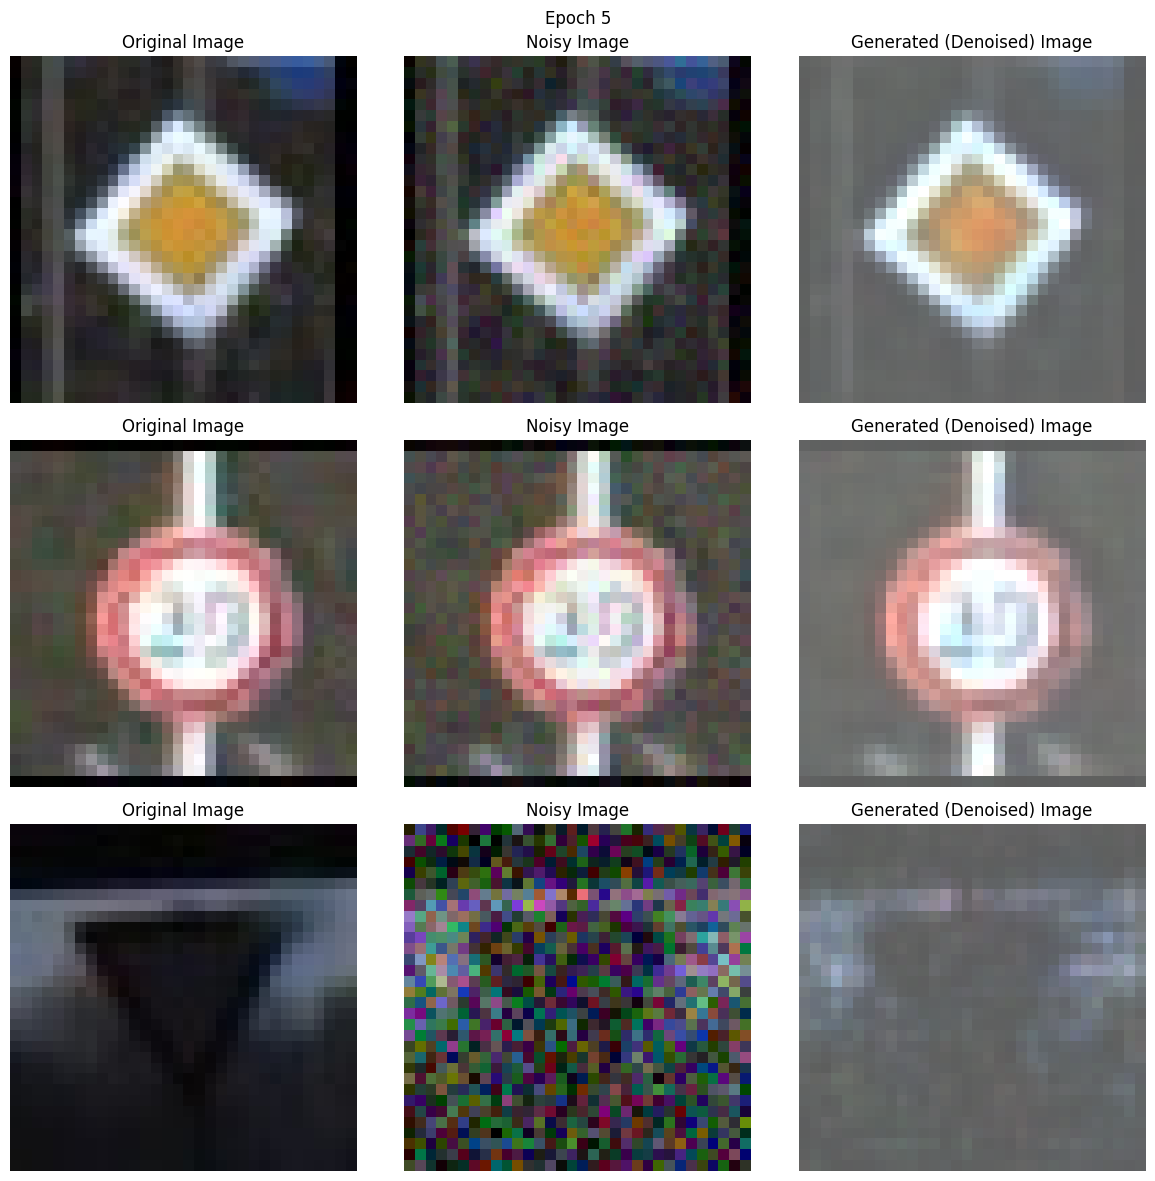

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:22<00:00, 24.13it/s]


Finished epoch 6. Average loss for this epoch: 0.186224
Sample 1:
Tensor min: -1.0000, max: -0.1765
Tensor min: -1.0000, max: -0.1485
Tensor min: -0.2785, max: -0.0000
Sample 2:
Tensor min: -0.8824, max: 1.0000
Tensor min: -0.9760, max: 1.0000
Tensor min: -0.2715, max: 1.3153
Sample 3:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2779, max: 1.3647


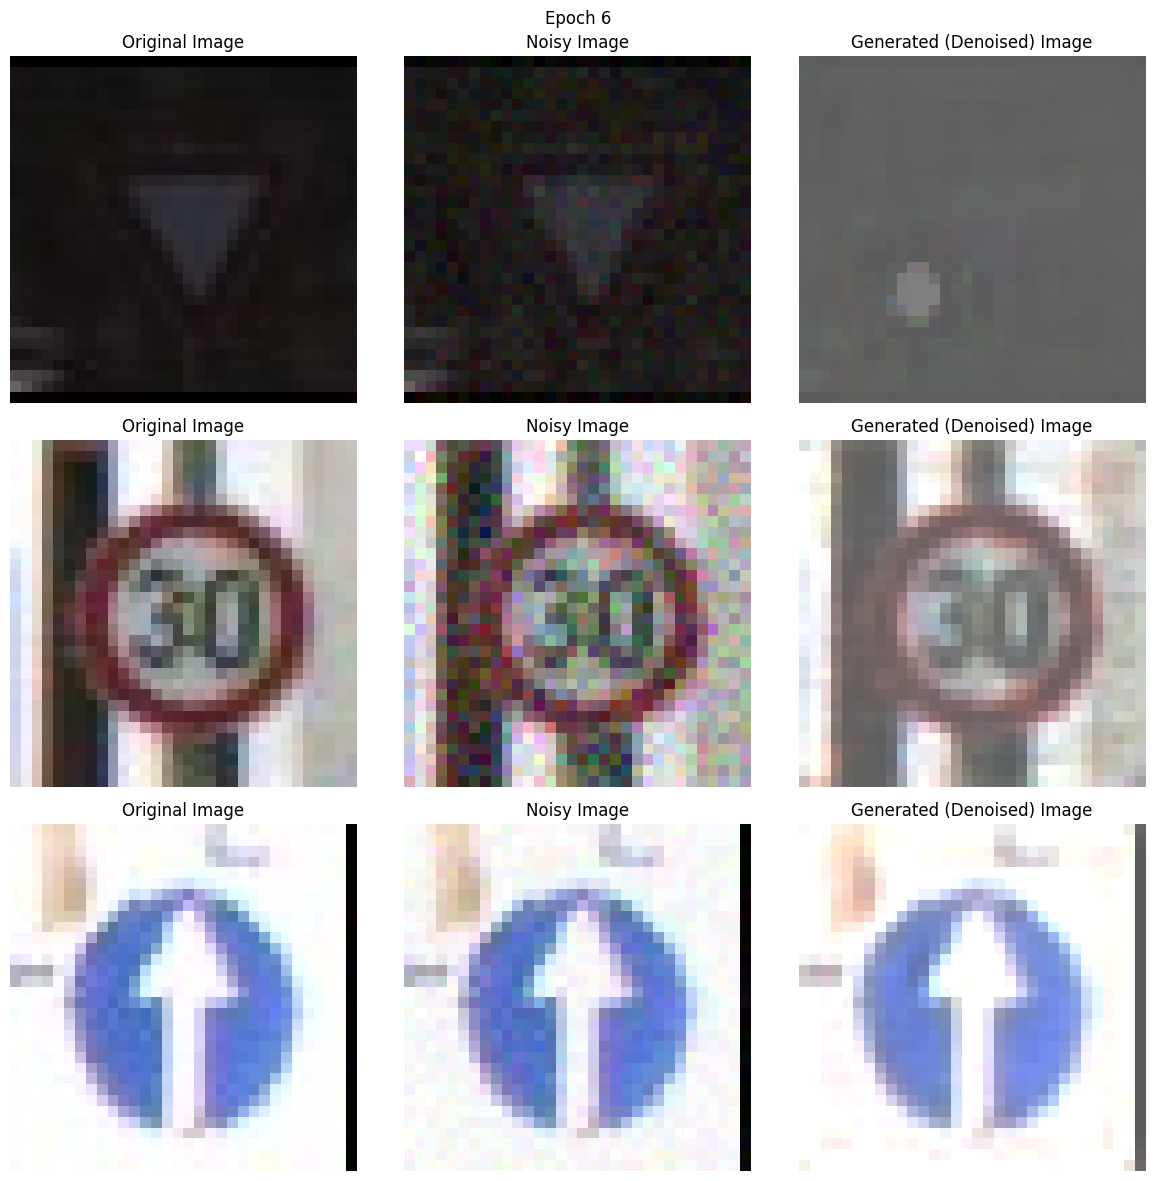

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:22<00:00, 24.14it/s]


Finished epoch 7. Average loss for this epoch: 0.180013
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.5961
Sample 2:
Tensor min: -1.0000, max: 0.7490
Tensor min: -1.0000, max: 0.7383
Tensor min: -0.2765, max: 0.9305
Sample 3:
Tensor min: -1.0000, max: 0.6000
Tensor min: -1.0000, max: 0.6781
Tensor min: -0.2783, max: 0.9424


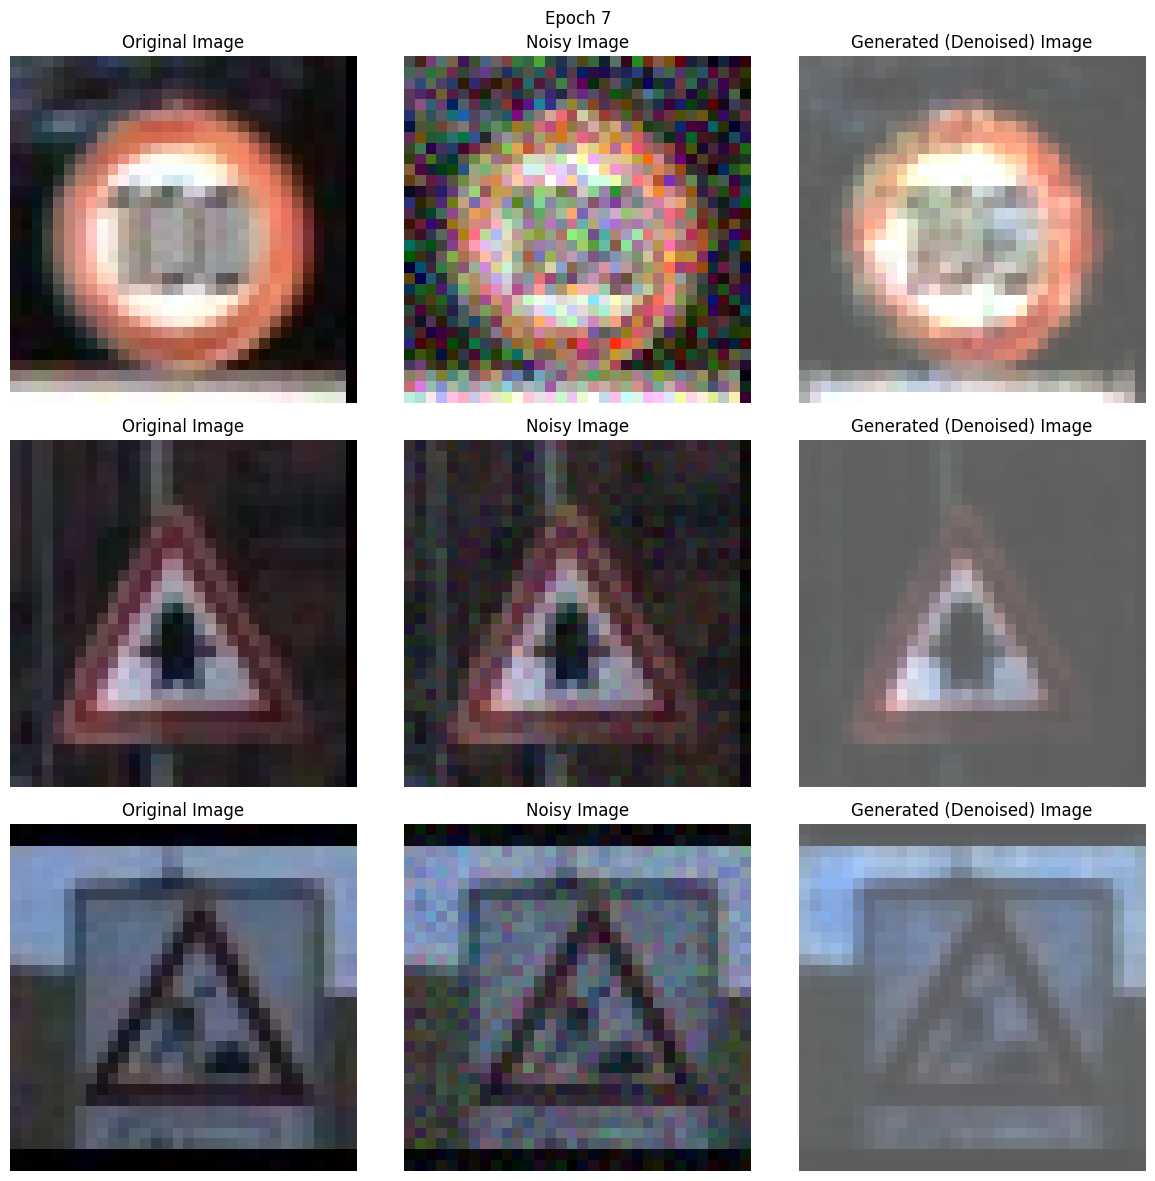

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:22<00:00, 24.18it/s]


Finished epoch 8. Average loss for this epoch: 0.173829
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2784, max: 1.3067
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.3988
Sample 3:
Tensor min: -1.0000, max: -0.1608
Tensor min: -1.0000, max: -0.0930
Tensor min: -0.2776, max: -0.1532


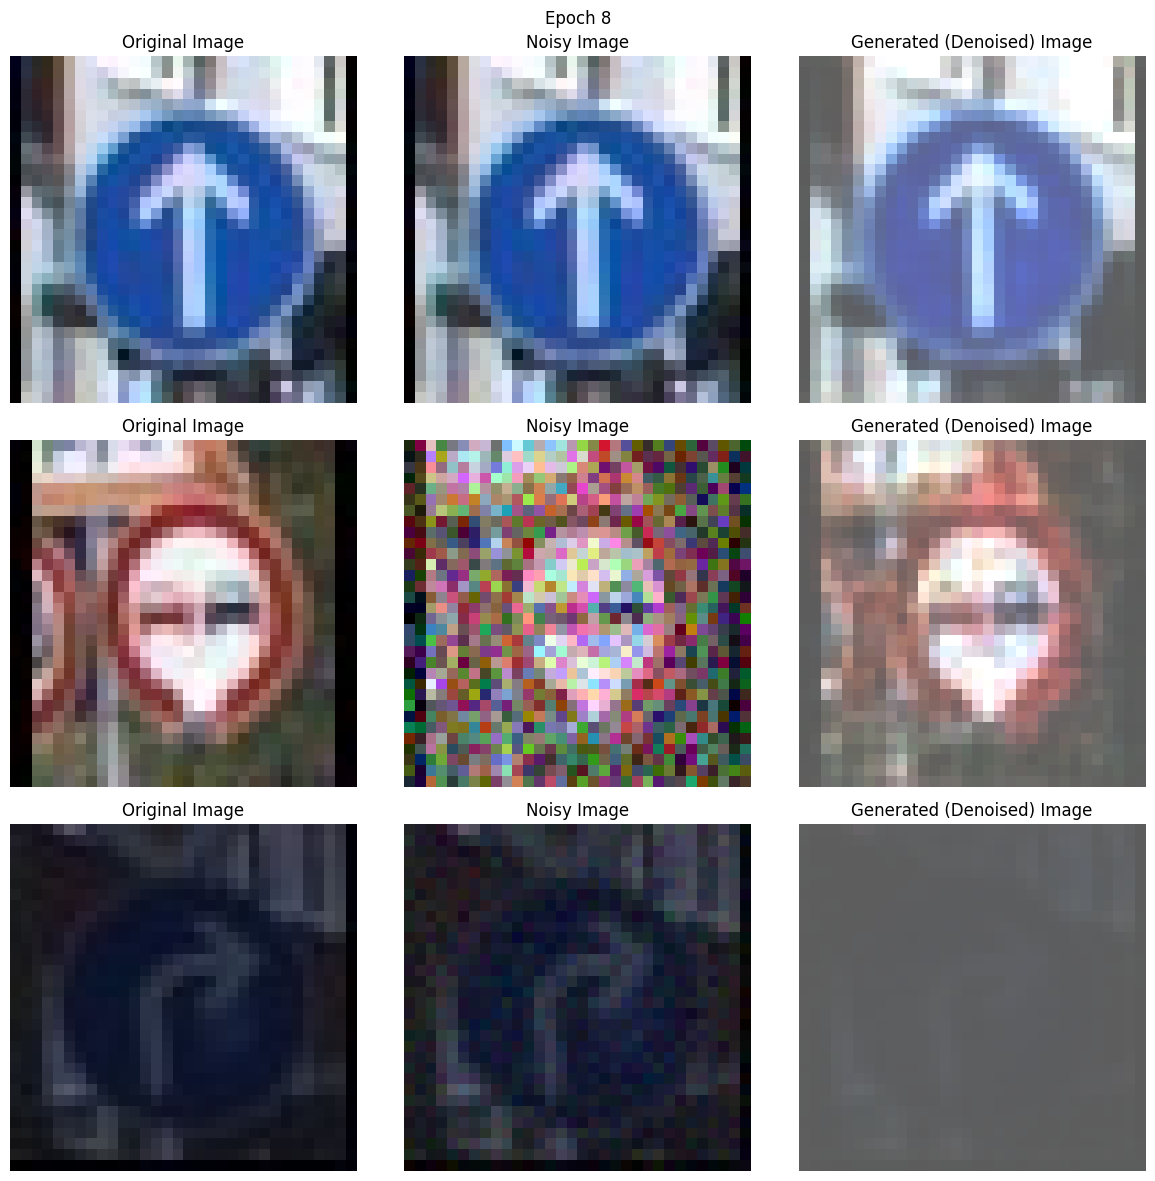

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:22<00:00, 24.18it/s]


Finished epoch 9. Average loss for this epoch: 0.168724
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2784, max: 1.1646
Sample 2:
Tensor min: -0.6941, max: 1.0000
Tensor min: -0.7058, max: 1.0000
Tensor min: -0.2725, max: 1.2711
Sample 3:
Tensor min: -1.0000, max: 0.7961
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 0.8912


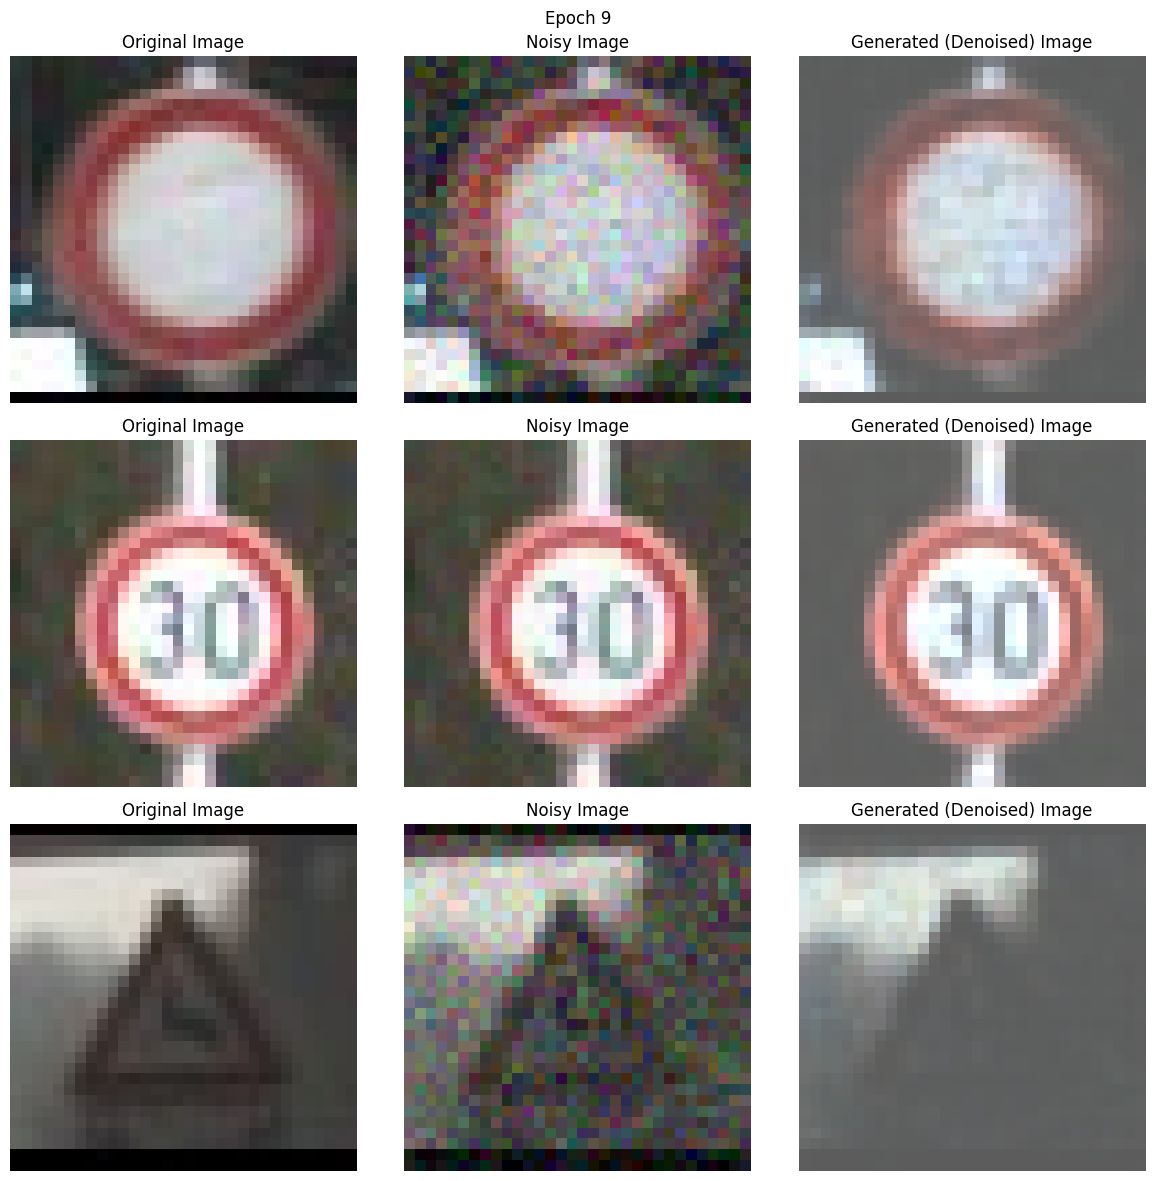

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:22<00:00, 24.06it/s]


Finished epoch 10. Average loss for this epoch: 0.165049
Sample 1:
Tensor min: -1.0000, max: -0.2549
Tensor min: -1.0000, max: -0.0118
Tensor min: -0.2784, max: -0.1969
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.1674
Sample 3:
Tensor min: -1.0000, max: 0.5294
Tensor min: -1.0000, max: 0.5237
Tensor min: -0.2785, max: 0.4053


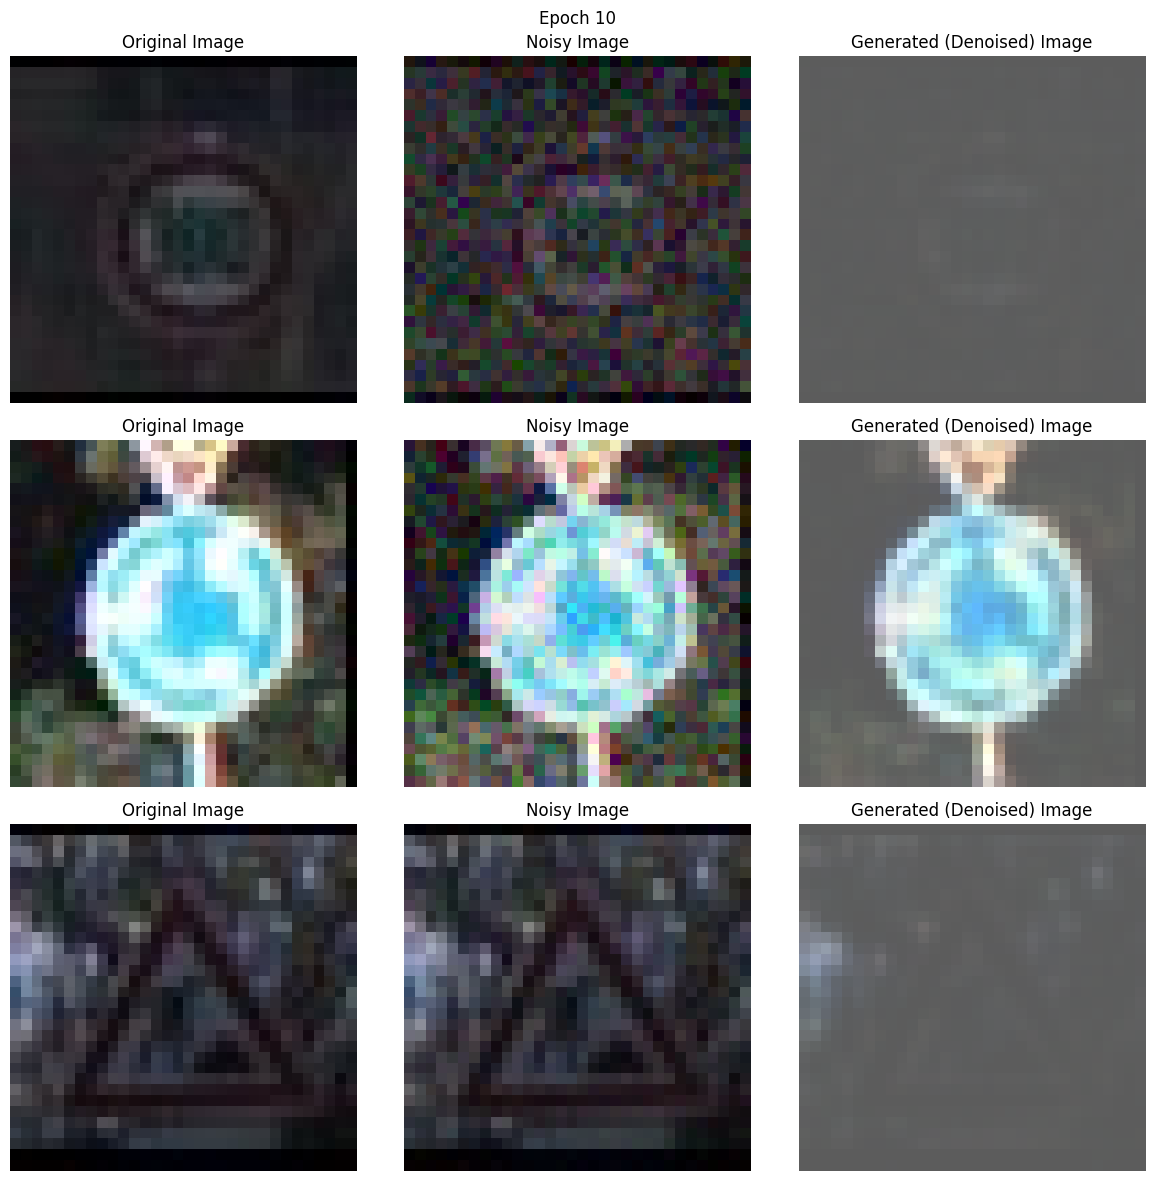

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:22<00:00, 24.10it/s]


Finished epoch 11. Average loss for this epoch: 0.161433
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.5813
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.5267
Sample 3:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.5941


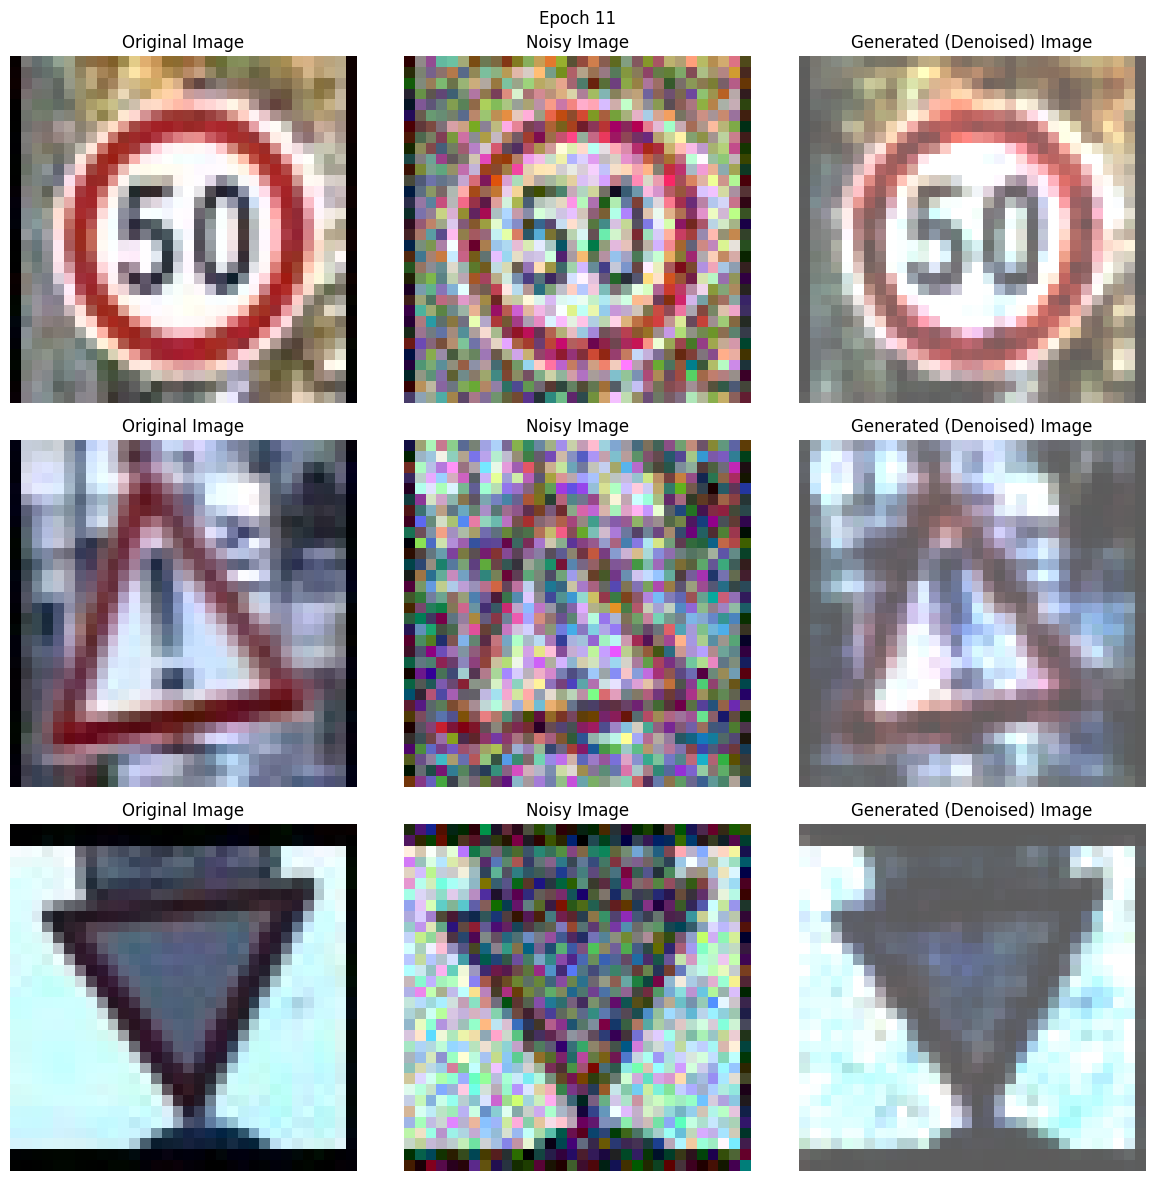

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:22<00:00, 24.08it/s]


Finished epoch 12. Average loss for this epoch: 0.158724
Sample 1:
Tensor min: -1.0000, max: -0.6314
Tensor min: -1.0000, max: -0.5064
Tensor min: -0.2785, max: -0.2545
Sample 2:
Tensor min: -1.0000, max: 0.2706
Tensor min: -1.0000, max: 0.7256
Tensor min: -0.2785, max: 0.5511
Sample 3:
Tensor min: -1.0000, max: 0.1216
Tensor min: -1.0000, max: 0.3109
Tensor min: -0.2785, max: 0.2471


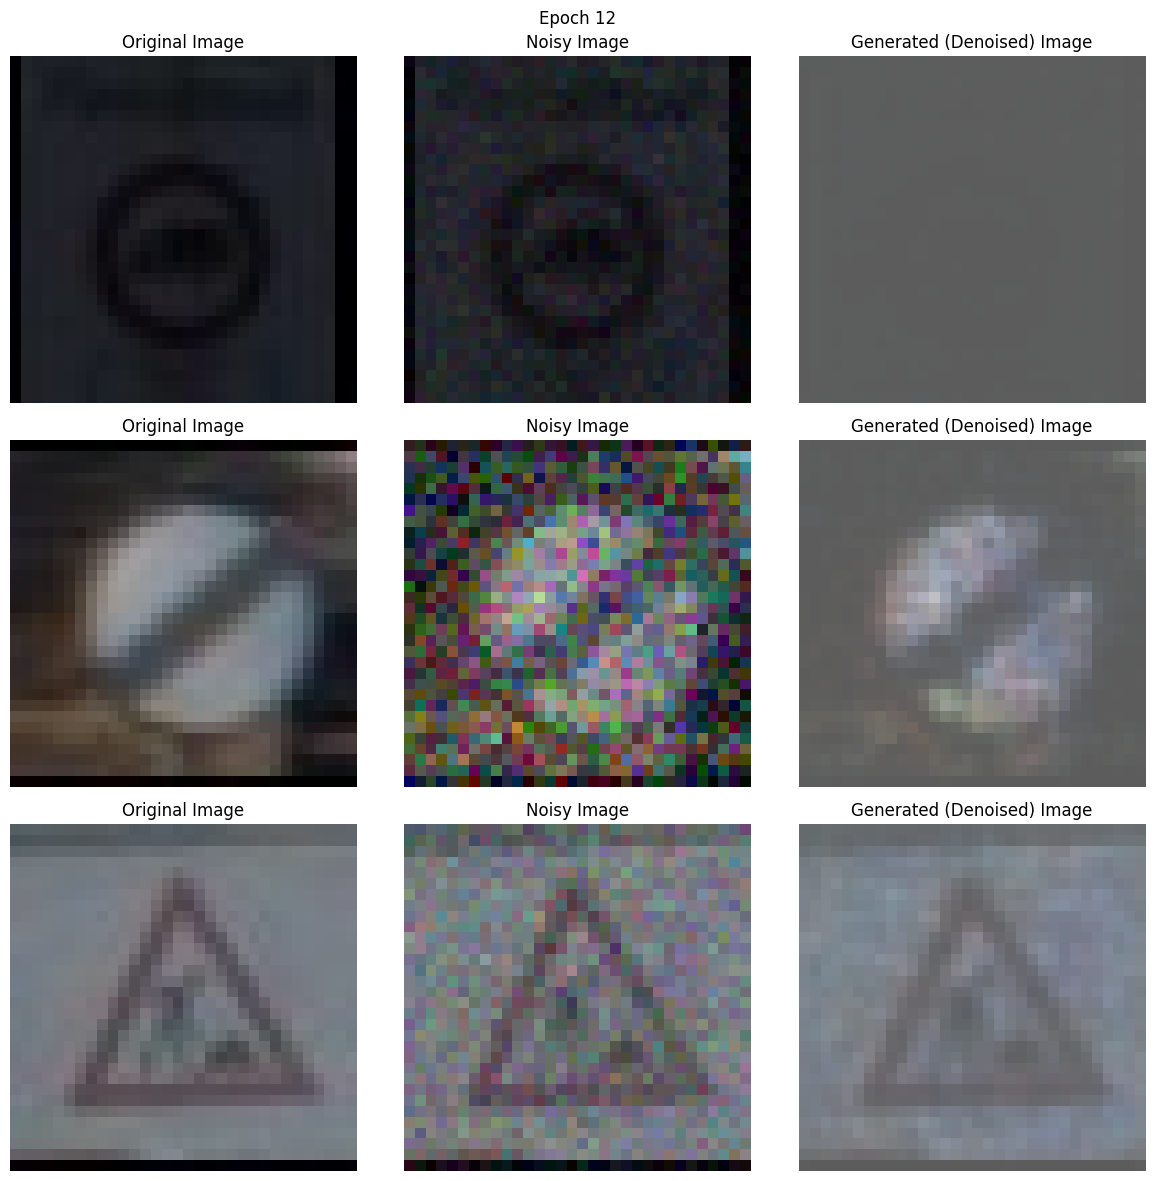

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.79it/s]


Finished epoch 13. Average loss for this epoch: 0.156394
Sample 1:
Tensor min: -1.0000, max: 0.7647
Tensor min: -1.0000, max: 0.8069
Tensor min: -0.2785, max: 0.8055
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.3184
Sample 3:
Tensor min: -0.7882, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.3171


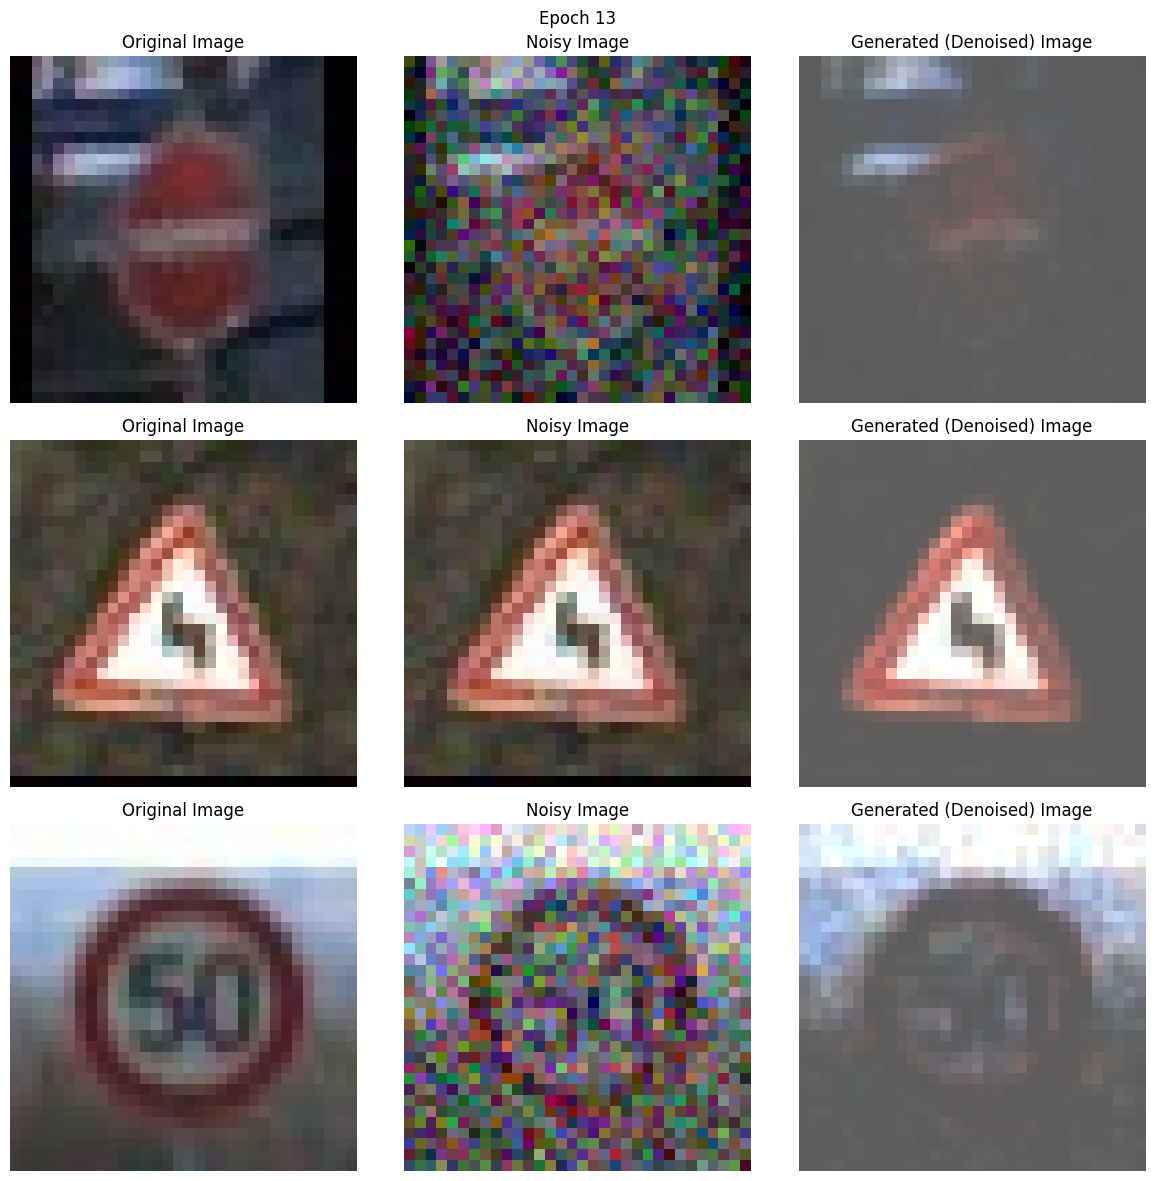

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:22<00:00, 24.09it/s]


Finished epoch 14. Average loss for this epoch: 0.154827
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.1492
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.1470
Sample 3:
Tensor min: -1.0000, max: -0.0667
Tensor min: -1.0000, max: 0.3462
Tensor min: -0.2785, max: -0.0163


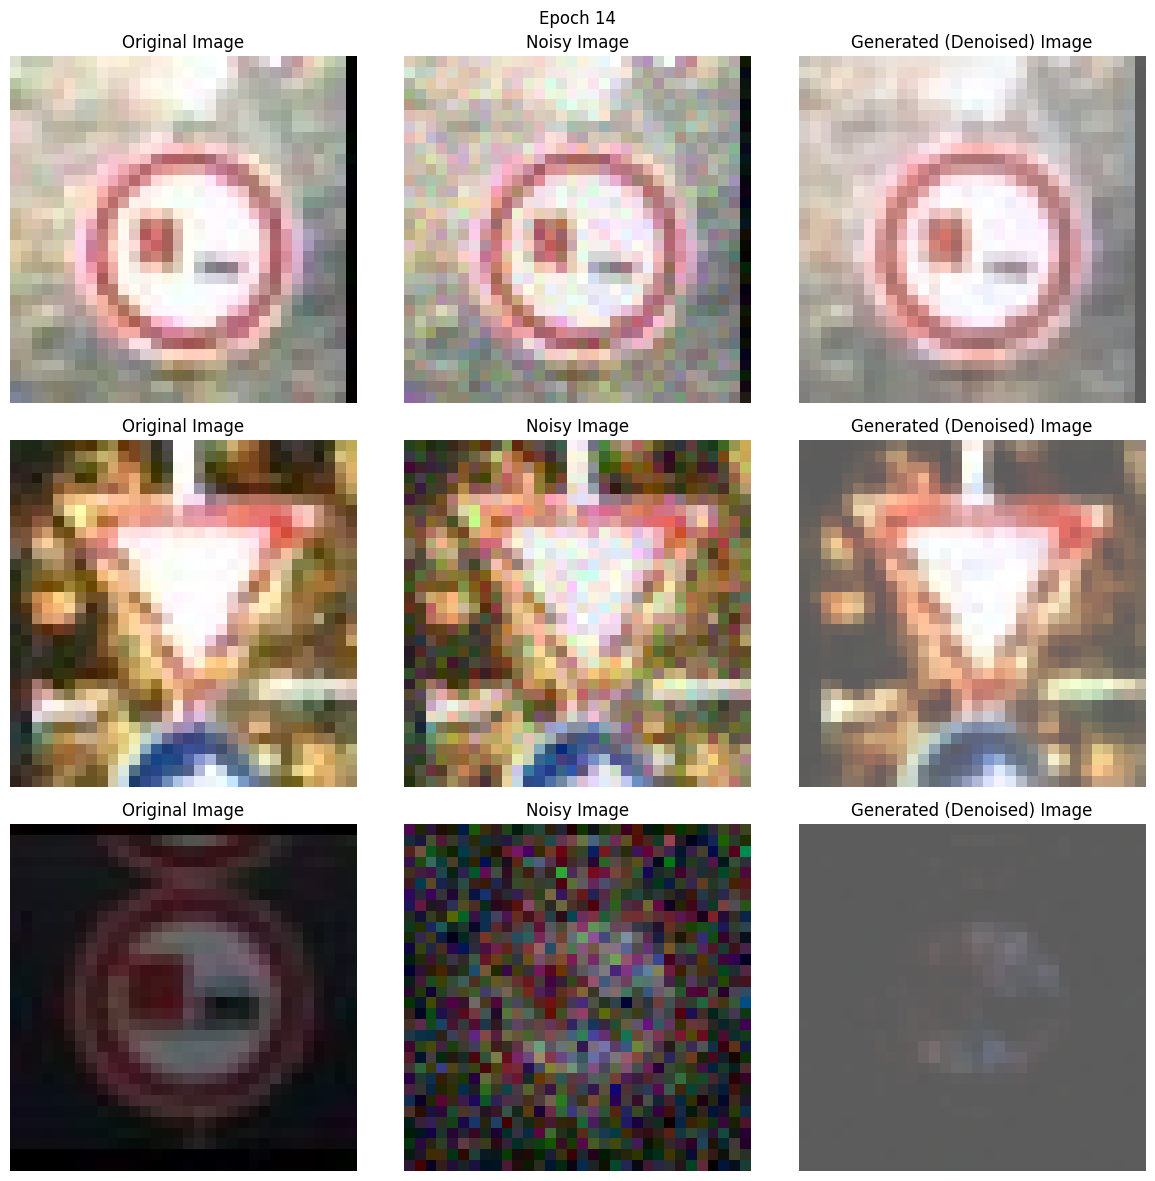

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.30it/s]


Finished epoch 15. Average loss for this epoch: 0.153682
Sample 1:
Tensor min: -1.0000, max: -0.2863
Tensor min: -1.0000, max: -0.0899
Tensor min: -0.2785, max: -0.2287
Sample 2:
Tensor min: -1.0000, max: -0.4196
Tensor min: -1.0000, max: -0.0962
Tensor min: -0.2785, max: -0.2584
Sample 3:
Tensor min: -0.9294, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.2467


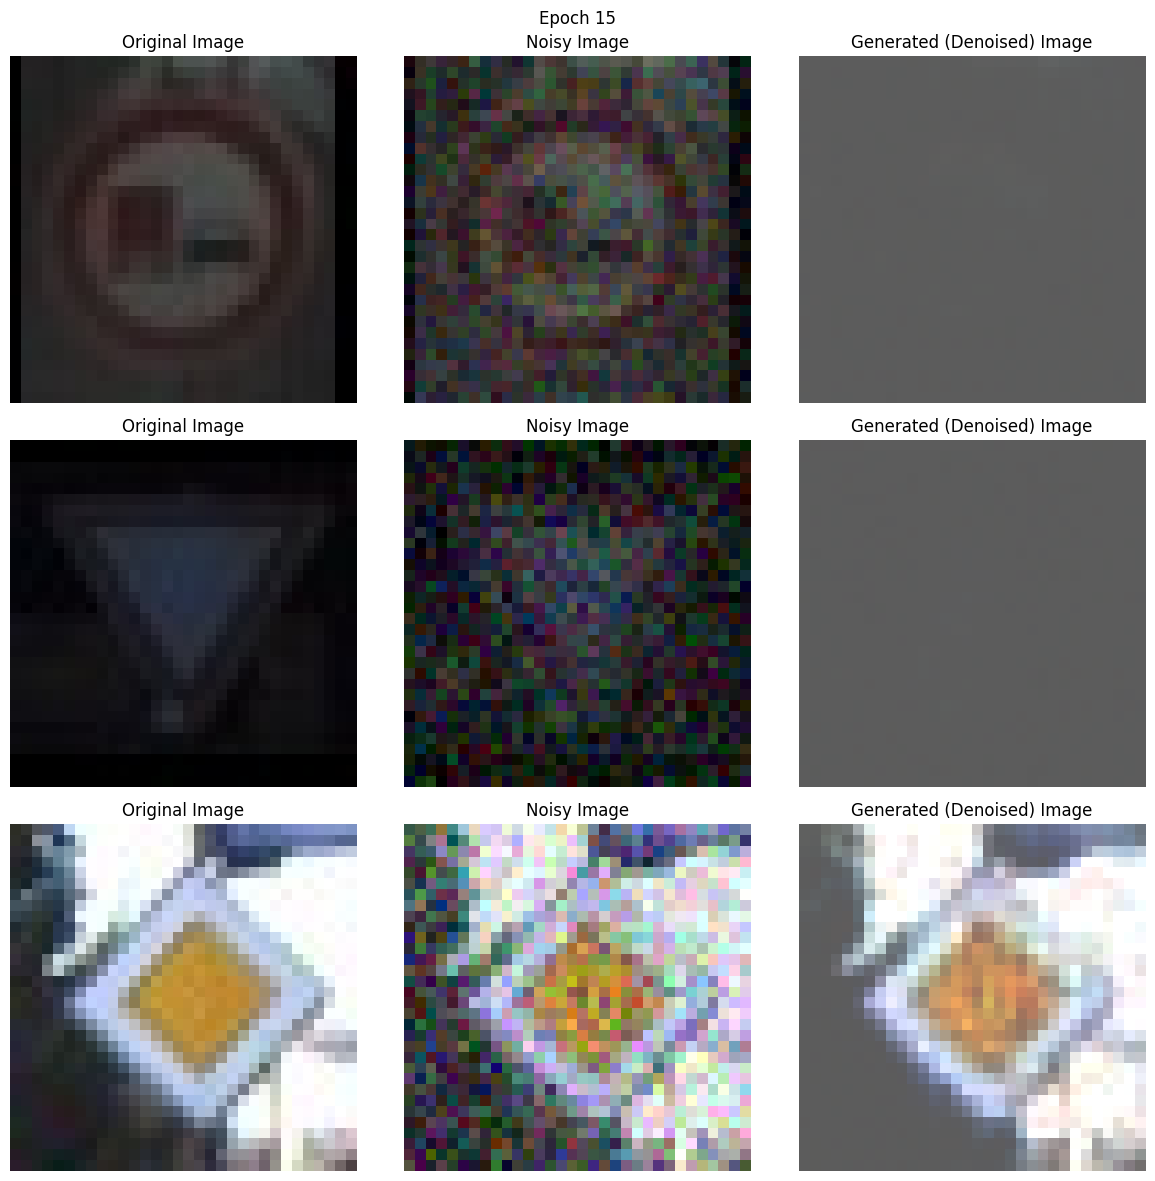

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.54it/s]


Finished epoch 16. Average loss for this epoch: 0.152566
Sample 1:
Tensor min: -0.9686, max: 1.0000
Tensor min: -0.9665, max: 1.0000
Tensor min: -0.2785, max: 1.1451
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.2272
Sample 3:
Tensor min: -1.0000, max: -0.6392
Tensor min: -1.0000, max: 0.0112
Tensor min: -0.2785, max: -0.2705


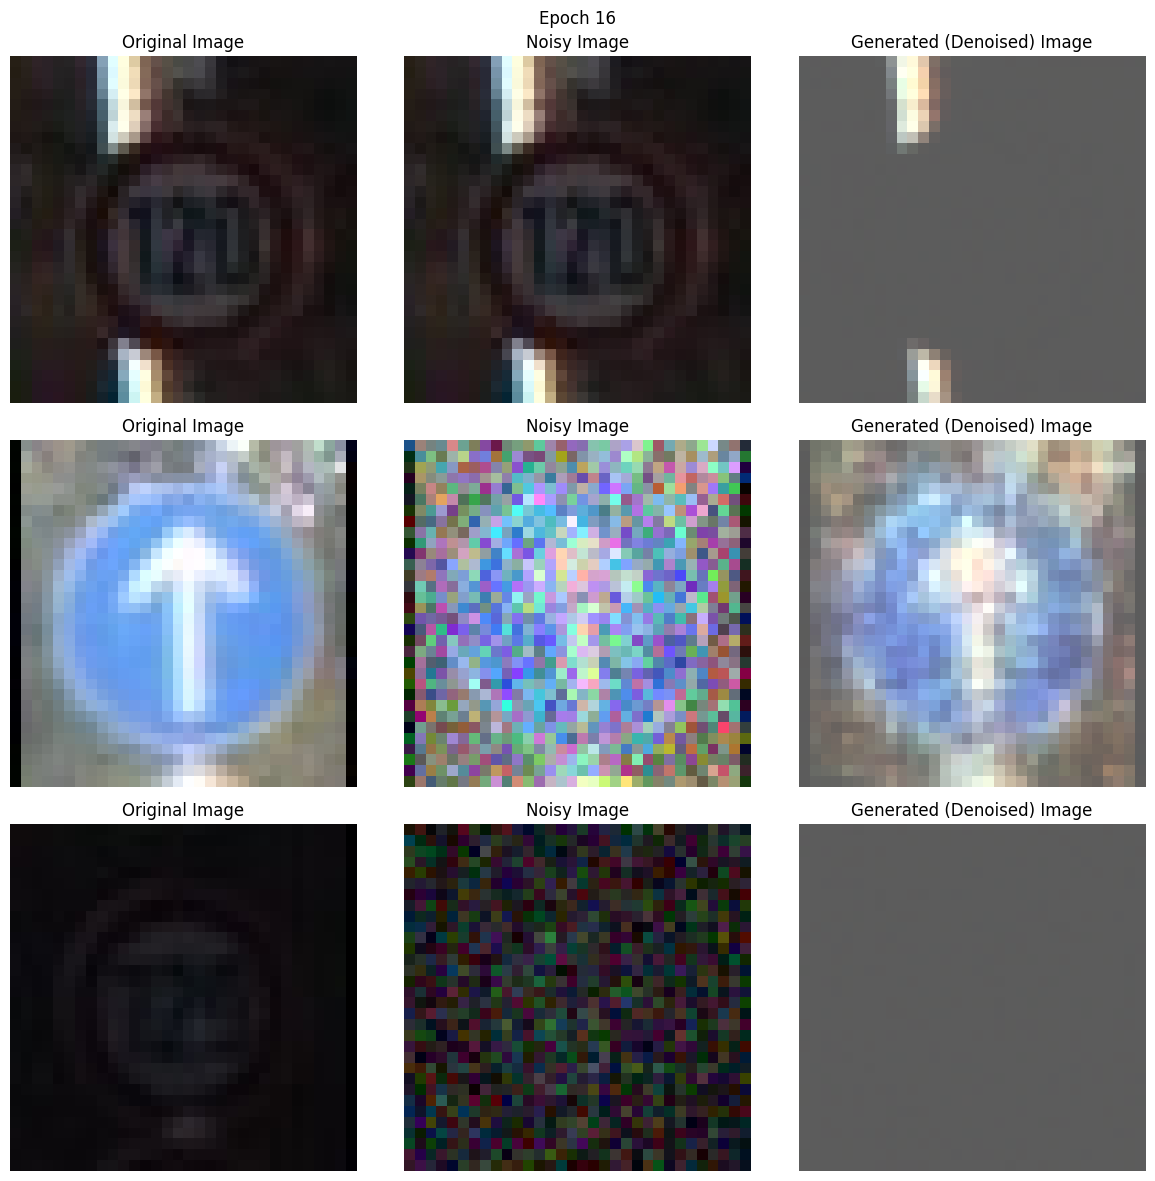

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.49it/s]


Finished epoch 17. Average loss for this epoch: 0.151965
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.6320
Sample 2:
Tensor min: -0.9451, max: -0.4275
Tensor min: -1.0000, max: 0.2301
Tensor min: -0.2785, max: -0.0652
Sample 3:
Tensor min: -1.0000, max: 0.6235
Tensor min: -1.0000, max: 0.6214
Tensor min: -0.2784, max: 0.9283


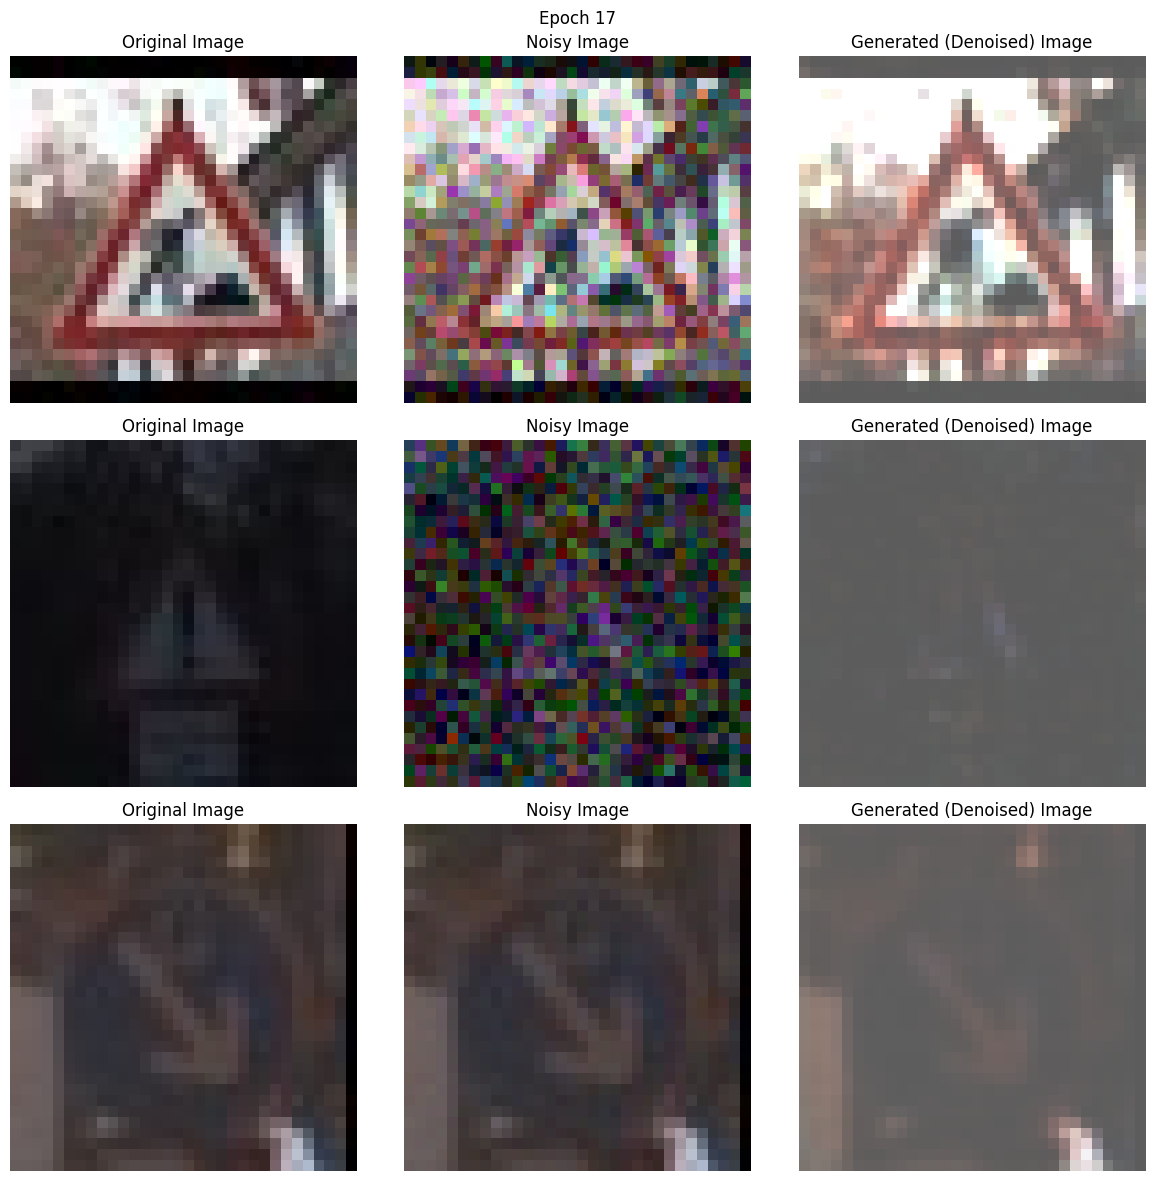

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.61it/s]


Finished epoch 18. Average loss for this epoch: 0.151585
Sample 1:
Tensor min: -0.9373, max: -0.1843
Tensor min: -1.0000, max: 0.0470
Tensor min: -0.2785, max: -0.1697
Sample 2:
Tensor min: -1.0000, max: 0.3961
Tensor min: -1.0000, max: 0.8407
Tensor min: -0.2785, max: 0.6276
Sample 3:
Tensor min: -0.8588, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.2873


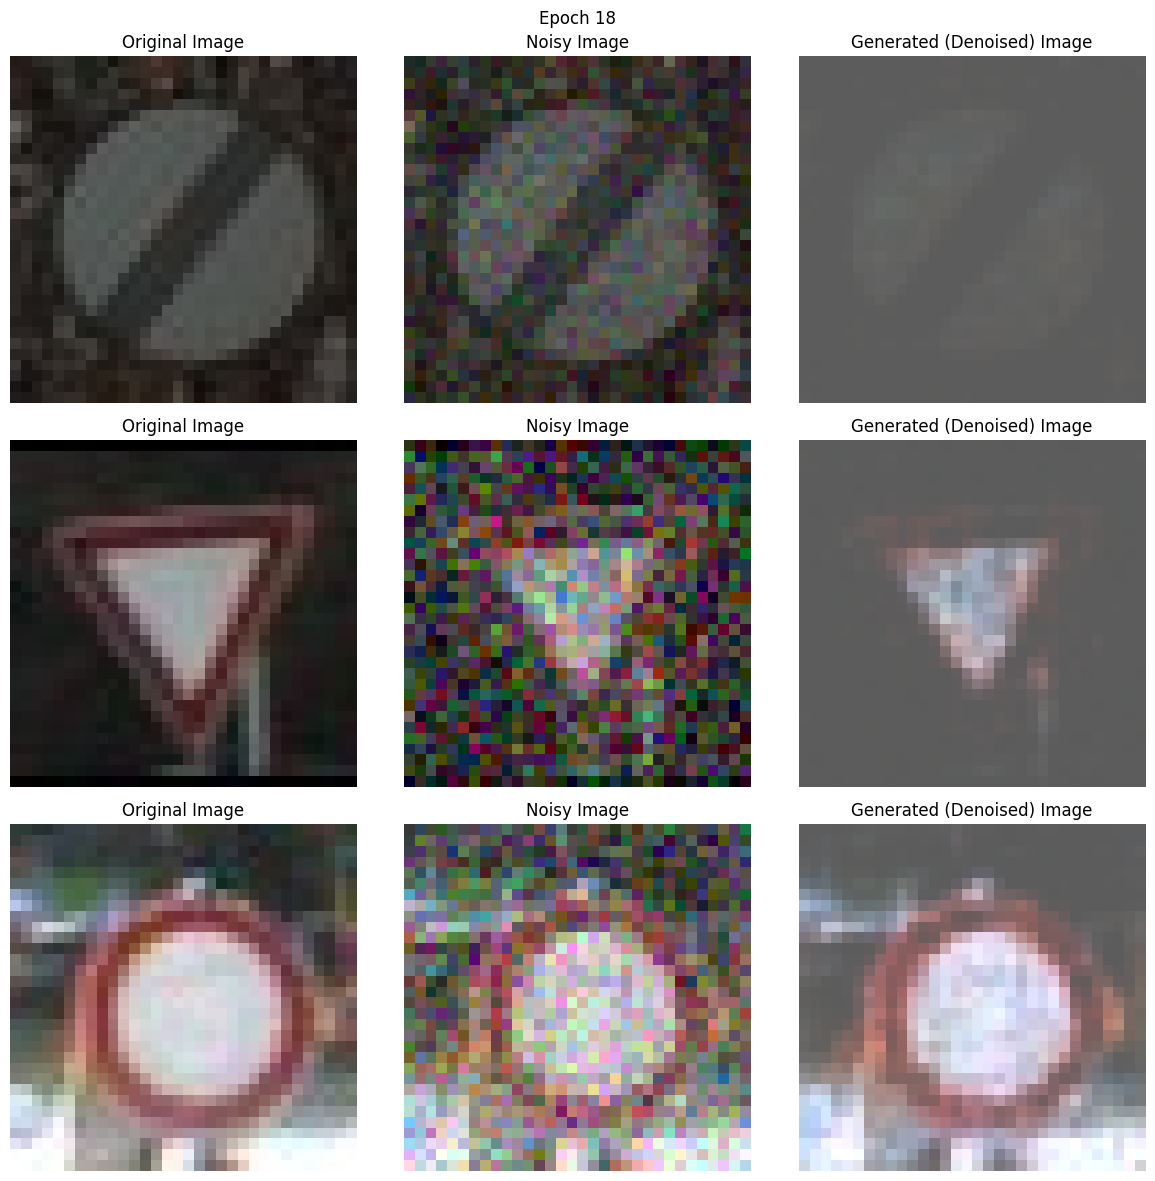

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.57it/s]


Finished epoch 19. Average loss for this epoch: 0.151074
Sample 1:
Tensor min: -0.8039, max: -0.1765
Tensor min: -0.8513, max: -0.1359
Tensor min: -0.2781, max: -0.1212
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.4077
Sample 3:
Tensor min: -1.0000, max: -0.2235
Tensor min: -1.0000, max: 0.5239
Tensor min: -0.2785, max: -0.1352


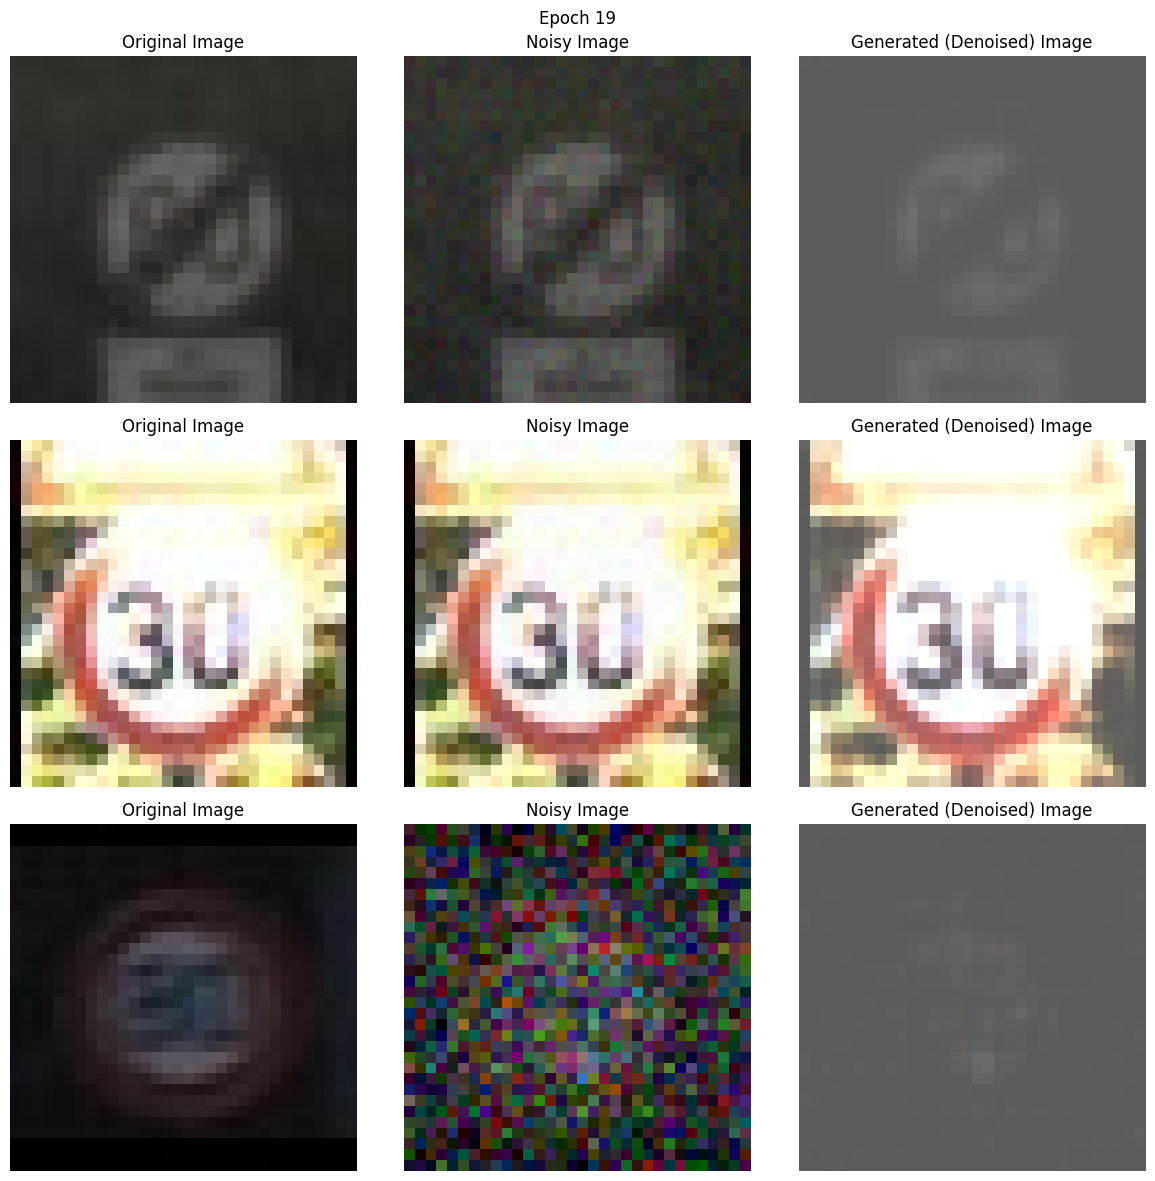

In [17]:
n_epochs = 20

net = BasicUNet()
net.to(device)

loss_fn = nn.MSELoss()

opt = torch.optim.Adam(net.parameters(), lr=1e-4)

losses = []

for epoch in range(n_epochs):

    for x, y in tqdm(train_loader):
        x = x.to(device)
        y = y.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device) * 0.3
        noisy_x = corrupt(x, noise_amount)

        pred = net(noisy_x, y, noise_amount)

        loss = loss_fn(pred, x)

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_loader):])/len(train_loader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

    with torch.no_grad():
        num_samples = min(3, x.shape[0])
        fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
        if num_samples == 1:
            axes = [axes]

        for i in range(num_samples):
            original = x[i]
            noisy = noisy_x[i]
            generated = pred[i]

            print(f"Sample {i+1}:")
            original_img = tensor_to_image(original, normalize=True)
            noisy_img = tensor_to_image(noisy, normalize=True)
            generated_img = tensor_to_image(generated, normalize=True)

            axes[i][0].imshow(original_img)
            axes[i][0].set_title('Original Image')
            axes[i][0].axis('off')

            axes[i][1].imshow(noisy_img)
            axes[i][1].set_title('Noisy Image')
            axes[i][1].axis('off')

            axes[i][2].imshow(generated_img)
            axes[i][2].set_title('Generated (Denoised) Image')
            axes[i][2].axis('off')

        plt.suptitle(f'Epoch {epoch}')
        plt.tight_layout()
        plt.show()

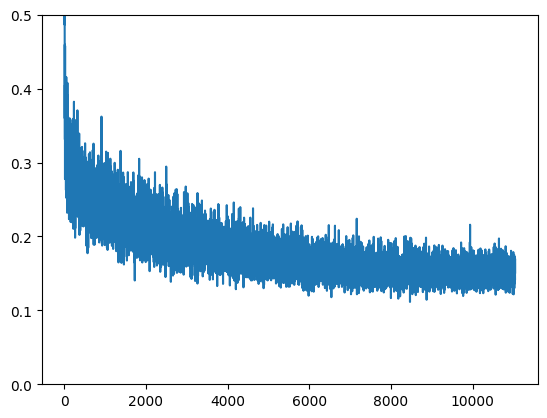

In [18]:
plt.plot(losses)
plt.ylim(0, 0.5);

In [19]:
import torch
import torchvision.transforms as T
from torchmetrics.image.fid import FrechetInceptionDistance
from tqdm import tqdm

fid = FrechetInceptionDistance(feature=2048, normalize=True).to(device)

transform = T.Compose([
    T.Resize((299, 299)),
    T.Normalize((0.5,), (0.5,)) if x.shape[1] == 1 else T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

net.eval()
with torch.no_grad():
    for x, y in tqdm(val_loader):
        x = x.to(device)
        y = y.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device) * 0.3
        noisy_x = corrupt(x, noise_amount)
        pred = net(noisy_x, y, noise_amount)

        for real_img, gen_img in zip(x, pred):
            real_img = transform(real_img).unsqueeze(0)
            gen_img = transform(gen_img).unsqueeze(0)
            fid.update(real_img, real=True)
            fid.update(gen_img, real=False)

fid_score = fid.compute()
print(f"FID score: {fid_score.item():.4f}")


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [01:49<00:00,  1.76s/it]


FID score: 88.8496


In [20]:
torch.save(net.state_dict(), 'unet-82-fid.pth')